In [4]:
# Cell 1 - imports and reload dataset
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib

# Use relative path (one folder up)
file_path = "../data/project_risk_raw_dataset.csv"

# Load dataset
df = pd.read_csv(file_path)

# Basic info
print("✅ Loaded successfully!")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist()[:10], "...")  # show first 10 column names
print("\nMissing values summary (top 5):")
print(df.isnull().sum().sort_values(ascending=False).head(5))

# Preview first 3 rows
df.head(3)

✅ Loaded successfully!
Shape: (4000, 51)

Columns: ['Project_ID', 'Project_Type', 'Team_Size', 'Project_Budget_USD', 'Estimated_Timeline_Months', 'Complexity_Score', 'Stakeholder_Count', 'Methodology_Used', 'Team_Experience_Level', 'Past_Similar_Projects'] ...

Missing values summary (top 5):
Tech_Environment_Stability      2619
Risk_Management_Maturity         791
Change_Control_Maturity          780
Project_ID                         0
Key_Stakeholder_Availability       0
dtype: int64


,Project_ID,Project_Type,Team_Size,Project_Budget_USD,Estimated_Timeline_Months,Complexity_Score,Stakeholder_Count,Methodology_Used,Team_Experience_Level,Past_Similar_Projects,...,Industry_Volatility,Client_Experience_Level,Change_Control_Maturity,Risk_Management_Maturity,Team_Colocation,Documentation_Quality,Project_Start_Month,Current_Phase_Duration_Months,Seasonal_Risk_Factor,Risk_Level
0,PROJ_0001,Construction,32,1526276.55,32,9.70,16,Waterfall,Senior,3,...,Extreme,First-time,Basic,Basic,Fully Colocated,Good,10,5,1.0,High
1,PROJ_0002,Manufacturing,2,390790.15,9,2.72,9,Kanban,Mixed,0,...,Stable,Occasional,Advanced,Formal,Fully Remote,Poor,9,3,1.0,Low
2,PROJ_0003,Manufacturing,2,246674.76,6,2.04,7,Agile,Mixed,1,...,Stable,Regular,NaN,NaN,Hybrid,Good,5,1,1.0,Medium


In [5]:
'Risk_Level' in df.columns


True

In [6]:
# Cell 2 - check target distribution
target_col = 'Risk_Level'
print("Target column:", target_col)
print("Unique values and counts:")
print(df[target_col].value_counts(dropna=False))


Target column: Risk_Level
Unique values and counts:
Risk_Level
Medium      1396
High        1036
Low          806
Critical     762
Name: count, dtype: int64


In [7]:
# Cell 3 - choose candidate features
exclude = {target_col, 'Project_ID'}   # exclude ID and target
# auto detect
numeric_features = df.select_dtypes(include=['int64','float64']).columns.difference(exclude).tolist()
categorical_features = df.select_dtypes(include=['object','category']).columns.difference(exclude).tolist()

print("Numeric features (count):", len(numeric_features))
print(numeric_features[:30])
print("\nCategorical features (count):", len(categorical_features))
print(categorical_features[:30])


Numeric features (count): 25
['Budget_Utilization_Rate', 'Change_Request_Frequency', 'Communication_Frequency', 'Complexity_Score', 'Cross_Functional_Dependencies', 'Current_Phase_Duration_Months', 'Estimated_Timeline_Months', 'External_Dependencies_Count', 'Geographical_Distribution', 'Historical_Risk_Incidents', 'Integration_Complexity', 'Market_Volatility', 'Organizational_Change_Frequency', 'Past_Similar_Projects', 'Previous_Delivery_Success_Rate', 'Project_Budget_USD', 'Project_Start_Month', 'Resource_Availability', 'Schedule_Pressure', 'Seasonal_Risk_Factor', 'Stakeholder_Count', 'Team_Size', 'Team_Turnover_Rate', 'Technical_Debt_Level', 'Vendor_Reliability_Score']

Categorical features (count): 24
['Change_Control_Maturity', 'Client_Experience_Level', 'Contract_Type', 'Data_Security_Requirements', 'Documentation_Quality', 'Executive_Sponsorship', 'Funding_Source', 'Industry_Volatility', 'Key_Stakeholder_Availability', 'Methodology_Used', 'Org_Process_Maturity', 'Priority_Level',

In [8]:
# Cell 4 - Recommended feature subset (numeric + categorical)

# Numeric features
numeric_features = [
    'Team_Size',
    'Project_Budget_USD',
    'Estimated_Timeline_Months',
    'Complexity_Score',
    'Stakeholder_Count',
    'Cross_Functional_Dependencies',
    'External_Dependencies_Count',
    'Team_Turnover_Rate',
    'Historical_Risk_Incidents',
    'Budget_Utilization_Rate',
    'Schedule_Pressure',
    'Previous_Delivery_Success_Rate',
    'Technical_Debt_Level',
    'Current_Phase_Duration_Months',
    'Seasonal_Risk_Factor'
]

# Categorical features
categorical_features = [
    'Project_Type',
    'Methodology_Used',
    'Team_Experience_Level',
    'Project_Phase',
    'Executive_Sponsorship',
    'Org_Process_Maturity',
    'Risk_Management_Maturity',
    'Priority_Level'
]

print("Using numeric features:", len(numeric_features))
print(numeric_features)
print("\nUsing categorical features:", len(categorical_features))
print(categorical_features)


Using numeric features: 15
['Team_Size', 'Project_Budget_USD', 'Estimated_Timeline_Months', 'Complexity_Score', 'Stakeholder_Count', 'Cross_Functional_Dependencies', 'External_Dependencies_Count', 'Team_Turnover_Rate', 'Historical_Risk_Incidents', 'Budget_Utilization_Rate', 'Schedule_Pressure', 'Previous_Delivery_Success_Rate', 'Technical_Debt_Level', 'Current_Phase_Duration_Months', 'Seasonal_Risk_Factor']

Using categorical features: 8
['Project_Type', 'Methodology_Used', 'Team_Experience_Level', 'Project_Phase', 'Executive_Sponsorship', 'Org_Process_Maturity', 'Risk_Management_Maturity', 'Priority_Level']


In [10]:
# Cell 5 - preprocessing pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Numeric preprocessing: fill missing values + scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: fill missing values + one-hot encode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine both into a single transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_features),
    ('cat', cat_transformer, categorical_features)
], remainder='drop')  # drop any other columns

print("✅ Preprocessing pipeline created successfully.")
print("Numeric features handled:", len(numeric_features))
print("Categorical features handled:", len(categorical_features))


✅ Preprocessing pipeline created successfully.
Numeric features handled: 15
Categorical features handled: 8


In [12]:
# Quick fix: Create 'models' directory if it doesn't exist
import os
os.makedirs('models', exist_ok=True)  # 'exist_ok=True' avoids errors if it already exists

# Now re-save the encoder
import joblib
joblib.dump(le, 'models/label_encoder.pkl')
print("✅ 'models/' folder created & label encoder saved!")

✅ 'models/' folder created & label encoder saved!


In [14]:
import os
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\dell\MSc_Project\AI_Risk_Assessor\notebooks


In [15]:
# Cell — Verify the saved label encoder
import joblib

# Step 1: Load the saved encoder from the 'models' folder
le_loaded = joblib.load('models/label_encoder.pkl')

# Step 2: Display stored class labels
print("✅ Label Encoder loaded successfully!")
print("Stored Classes:", le_loaded.classes_)

# Step 3: Test encoding and decoding
sample_labels = ['Low', 'Critical', 'Medium']
encoded = le_loaded.transform(sample_labels)
decoded = le_loaded.inverse_transform(encoded)

print("\nExample Encoding:")
for label, code in zip(sample_labels, encoded):
    print(f"  {label:>8} → {code}")

print("\nExample Decoding:")
for code, label in zip(encoded, decoded):
    print(f"  {code} → {label}")


✅ Label Encoder loaded successfully!
Stored Classes: ['Critical' 'High' 'Low' 'Medium']

Example Encoding:
       Low → 2
  Critical → 0
    Medium → 3

Example Decoding:
  2 → Low
  0 → Critical
  3 → Medium


In [13]:
# Cell 6 - Label encoding and train/test split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 1: Encode the target variable (Risk_Level) to numeric labels
le = LabelEncoder()
df['Risk_Level_Encoded'] = le.fit_transform(df['Risk_Level'])  # Fits on whole df for simplicity (small dataset; in prod, fit only on train)

# Quick check: See the mapping (e.g., {'Critical': 0, 'High': 1, 'Low': 2, 'Medium': 3})
print("Target label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Step 2: Prepare features (X) and target (y)
X = df.drop(['Risk_Level', 'Risk_Level_Encoded'], axis=1)  # Drop original + encoded for clean X
y = df['Risk_Level_Encoded']  # Use encoded y

# Step 3: Split into train/test (80/20, stratified for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # random_state for reproducibility
)

# Step 4: Fit preprocessor on train and transform both
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)  # No fit here!

# Output shapes and class distribution check
print("\n✅ Train/Test split complete!")
print(f"X_train shape: {X_train_processed.shape}")
print(f"X_test shape: {X_test_processed.shape}")
print(f"y_train distribution:\n{pd.Series(y_train).value_counts().sort_index()}")
print(f"y_test distribution:\n{pd.Series(y_test).value_counts().sort_index()}")

# Optional: Save the label encoder for later (inverse transform predictions back to labels)
import joblib
joblib.dump(le, 'models/label_encoder.pkl')
print("\n💾 Label encoder saved as 'models/label_encoder.pkl'")

Target label mapping: {'Critical': np.int64(0), 'High': np.int64(1), 'Low': np.int64(2), 'Medium': np.int64(3)}

✅ Train/Test split complete!
X_train shape: (3200, 50)
X_test shape: (800, 50)
y_train distribution:
Risk_Level_Encoded
0     609
1     829
2     645
3    1117
Name: count, dtype: int64
y_test distribution:
Risk_Level_Encoded
0    153
1    207
2    161
3    279
Name: count, dtype: int64

💾 Label encoder saved as 'models/label_encoder.pkl'


C:\Users\dell\anaconda3\envs\ai_risk\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Logistic Regression Accuracy: 0.5112

Classification Report:
              precision    recall  f1-score   support

    Critical       0.59      0.61      0.60       153
        High       0.45      0.30      0.36       207
         Low       0.53      0.47      0.50       161
      Medium       0.49      0.63      0.55       279

    accuracy                           0.51       800
   macro avg       0.52      0.51      0.50       800
weighted avg       0.51      0.51      0.50       800



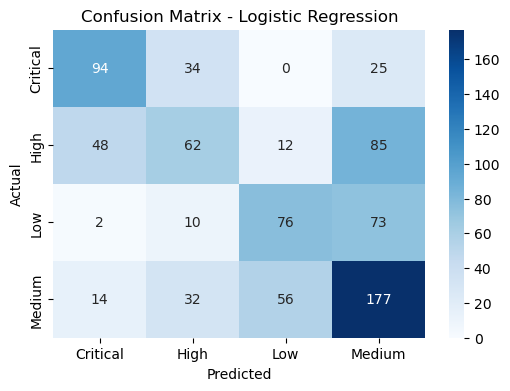


💾 Model saved as 'models/logistic_regression_model.pkl'


In [16]:
# Cell 7 - Logistic Regression Baseline Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Initialize the model
log_reg = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')

# Step 2: Train (fit) on the processed training data
log_reg.fit(X_train_processed, y_train)

# Step 3: Predict on test data
y_pred = log_reg.predict(X_test_processed)

# Step 4: Evaluate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Logistic Regression Accuracy: {acc:.4f}")

# Step 5: Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Step 6: Confusion matrix for visual insight
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Step 7: Save the trained model
import joblib
joblib.dump(log_reg, 'models/logistic_regression_model.pkl')
print("\n💾 Model saved as 'models/logistic_regression_model.pkl'")



✅ Random Forest Accuracy: 0.5062

Classification Report:
              precision    recall  f1-score   support

    Critical       0.66      0.52      0.58       153
        High       0.43      0.33      0.37       207
         Low       0.58      0.40      0.47       161
      Medium       0.47      0.69      0.56       279

    accuracy                           0.51       800
   macro avg       0.53      0.49      0.50       800
weighted avg       0.52      0.51      0.50       800



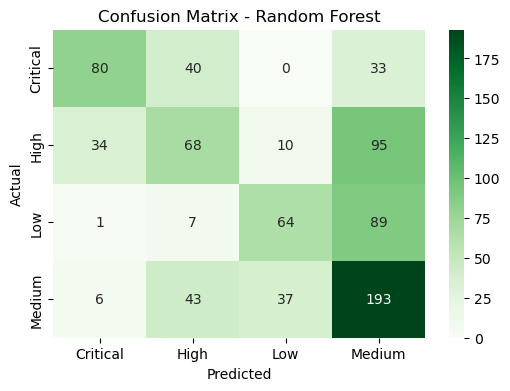


💾 Model saved as 'models/random_forest_model.pkl'


In [17]:
# Cell 8 - Random Forest Model Training & Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Step 1: Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,       # number of trees in the forest
    max_depth=None,         # let trees grow fully (can tune later)
    random_state=42,
    n_jobs=-1               # use all CPU cores for speed
)

# Step 2: Train the model
rf_model.fit(X_train_processed, y_train)

# Step 3: Predict on test data
y_pred_rf = rf_model.predict(X_test_processed)

# Step 4: Evaluate performance
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"✅ Random Forest Accuracy: {acc_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Step 5: Confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Step 6: Save model
joblib.dump(rf_model, 'models/random_forest_model.pkl')
print("\n💾 Model saved as 'models/random_forest_model.pkl'")


✅ Model Performance Comparison:
                 Model  Accuracy  F1-Score
0  Logistic Regression    0.5112    0.5021
1        Random Forest    0.5062    0.4982


C:\Users\dell\AppData\Local\Temp\ipykernel_557476\230565206.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results, palette='cool')


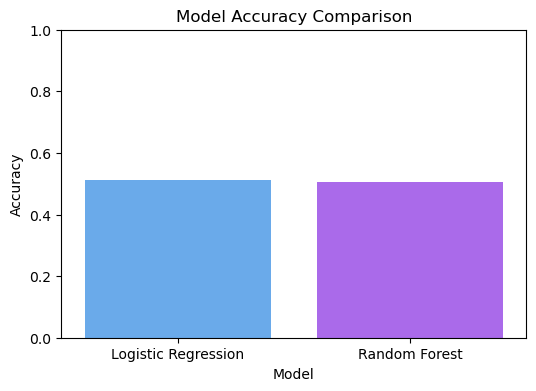

C:\Users\dell\AppData\Local\Temp\ipykernel_557476\230565206.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='Greens_r')


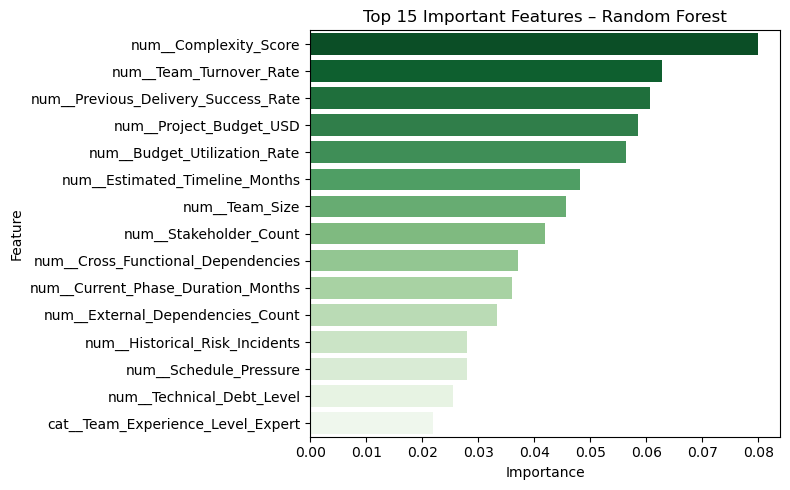

💾 Top 15 feature importances saved to 'models/feature_importance_top15.csv'


In [20]:
# Cell 9 — Compare Models & Show Feature Importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
import joblib

# Step 1️⃣ – Load saved models (safety check)
log_reg_loaded = joblib.load('models/logistic_regression_model.pkl')
rf_loaded      = joblib.load('models/random_forest_model.pkl')

# Step 2️⃣ – Compare overall performance
acc_log = accuracy_score(y_test, log_reg_loaded.predict(X_test_processed))
acc_rf  = accuracy_score(y_test, rf_loaded.predict(X_test_processed))
f1_log  = f1_score(y_test, log_reg_loaded.predict(X_test_processed), average='weighted')
f1_rf   = f1_score(y_test, rf_loaded.predict(X_test_processed), average='weighted')

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [acc_log, acc_rf],
    'F1-Score': [f1_log, f1_rf]
})

print("✅ Model Performance Comparison:")
print(results.round(4))

# Step 3️⃣ – Visualize comparison
plt.figure(figsize=(6,4))
sns.barplot(x='Model', y='Accuracy', data=results, palette='cool')
plt.title('Model Accuracy Comparison')
plt.ylim(0,1)
plt.show()

# Step 4️⃣ – Feature importance (Random Forest)
if hasattr(rf_loaded, 'feature_importances_'):
    feature_names = preprocessor.get_feature_names_out()
    importances = rf_loaded.feature_importances_
    feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(8,5))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='Greens_r')
    #sns.barplot(x='Model', y='Accuracy', data=results, hue='Model', legend=False, palette='cool')
    plt.title('Top 15 Important Features – Random Forest')
    plt.tight_layout()
    plt.show()

    feat_imp_df.to_csv('models/feature_importance_top15.csv', index=False)
    print("💾 Top 15 feature importances saved to 'models/feature_importance_top15.csv'")
else:
    print("⚠️ Feature importance not available for this model.")


In [21]:
# Cell 10 - Hyperparameter Tuning for Random Forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import joblib

# Step 1️⃣ - Define the model
rf_tune = RandomForestClassifier(random_state=42, n_jobs=-1)

# Step 2️⃣ - Define hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Step 3️⃣ - Set up grid search (5-fold cross-validation)
grid_search = GridSearchCV(
    estimator=rf_tune,
    param_grid=param_grid,
    cv=5,               # 5 different train/test splits
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

# Step 4️⃣ - Run the search on training data
grid_search.fit(X_train_processed, y_train)

# Step 5️⃣ - Get best parameters and accuracy
print("\n✅ Best Parameters Found:")
print(grid_search.best_params_)

print(f"\n✅ Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Step 6️⃣ - Evaluate on test set
best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test_processed)
test_acc = accuracy_score(y_test, y_pred_best)

print(f"\n✅ Test Set Accuracy (After Tuning): {test_acc:.4f}")

# Step 7️⃣ - Save tuned model
joblib.dump(best_rf_model, 'models/random_forest_tuned.pkl')
print("\n💾 Tuned Random Forest model saved as 'models/random_forest_tuned.pkl'")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits

✅ Best Parameters Found:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

✅ Best Cross-Validation Accuracy: 0.4925

✅ Test Set Accuracy (After Tuning): 0.4913

💾 Tuned Random Forest model saved as 'models/random_forest_tuned.pkl'


✅ Final Model Performance Comparison:
                      Model  Accuracy
0       Logistic Regression    0.5112
1  Random Forest (Baseline)    0.5062
2     Random Forest (Tuned)    0.4912


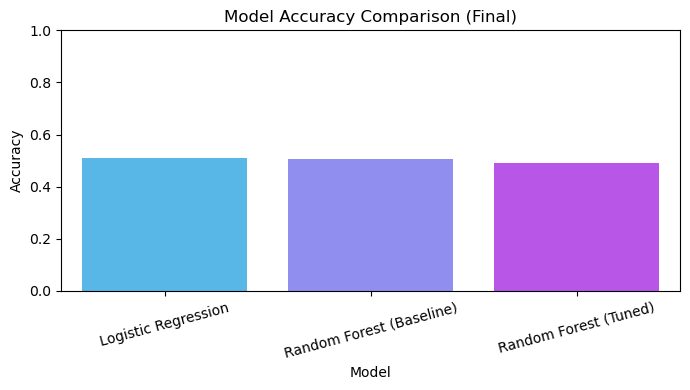

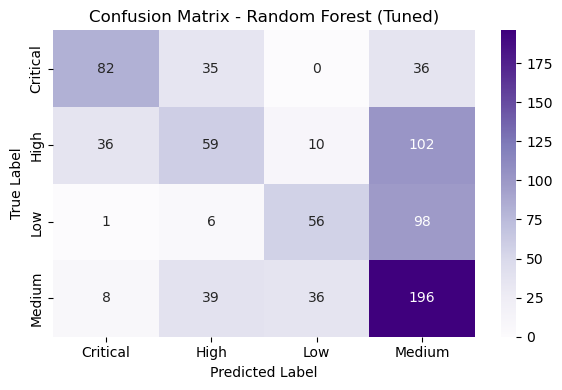


Classification Report - Random Forest (Tuned):
              precision    recall  f1-score   support

    Critical       0.65      0.54      0.59       153
        High       0.42      0.29      0.34       207
         Low       0.55      0.35      0.43       161
      Medium       0.45      0.70      0.55       279

    accuracy                           0.49       800
   macro avg       0.52      0.47      0.48       800
weighted avg       0.50      0.49      0.48       800


💾 Final comparison saved as 'models/final_model_comparison.csv'


In [22]:
# Cell 11 - Final Evaluation & Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Step 1️⃣ - Load all three models
log_reg_model = joblib.load('models/logistic_regression_model.pkl')
rf_baseline   = joblib.load('models/random_forest_model.pkl')
rf_tuned      = joblib.load('models/random_forest_tuned.pkl')

# Step 2️⃣ - Evaluate on test data
acc_log = accuracy_score(y_test, log_reg_model.predict(X_test_processed))
acc_rf_base = accuracy_score(y_test, rf_baseline.predict(X_test_processed))
acc_rf_tuned = accuracy_score(y_test, rf_tuned.predict(X_test_processed))

results_final = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest (Baseline)', 'Random Forest (Tuned)'],
    'Accuracy': [acc_log, acc_rf_base, acc_rf_tuned]
})

print("✅ Final Model Performance Comparison:")
print(results_final.round(4))

# Step 3️⃣ - Bar chart comparison
plt.figure(figsize=(7,4))
sns.barplot(x='Model', y='Accuracy', data=results_final, hue='Model', legend=False, palette='cool')
plt.title('Model Accuracy Comparison (Final)')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Step 4️⃣ - Confusion Matrix for Tuned Model
y_pred_tuned = rf_tuned.predict(X_test_processed)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6,4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Step 5️⃣ - Classification Report for Tuned Model
print("\nClassification Report - Random Forest (Tuned):")
print(classification_report(y_test, y_pred_tuned, target_names=le.classes_))

# Step 6️⃣ - Save final results for report
results_final.to_csv('models/final_model_comparison.csv', index=False)
print("\n💾 Final comparison saved as 'models/final_model_comparison.csv'")
